## __Load Data__

In [ ]:
import pandas as pd
import numpy as np
from statsbombpy import sb
from ast import literal_eval
from dataloader import load_data
import matplotlib.pyplot as plt
from mplsoccer import Pitch, VerticalPitch



columns = ['player','location','under_pressure','pass_aerial_won','pass_angle','pass_assisted_shot_id','pass_body_part',
 'pass_cross','pass_cut_back','pass_deflected','pass_end_location','pass_goal_assist','pass_shot_assist','pass_height',
 'pass_inswinging','pass_length','pass_outcome','pass_outswinging','pass_recipient','pass_recipient_id',
 'pass_switch','pass_technique','pass_through_ball','pass_type','shot_key_pass_id']


def load_event_data(match=False):
    if match:
        COMPETITION_ID = 9
        SEASON_ID = 27
        MATCH_ID = 3890561 
        events = sb.events(match_id=MATCH_ID)
        df = events.loc[events["type"] == "Pass", columns] # [row, column] selector
        print(df.shape, df.columns)
        return df
    else:
        df = load_data(frac=0.1)
        df = df.loc[df["type"] == "Pass", columns] 
        print(df.shape, df.columns)
        return df

MATCH=False

df = load_event_data(match=MATCH)

Loading data form local file system


/Users/alexanderlorenz/Documents/GitHub/ai-fc/src/dataloader.py:33: DtypeWarning: Columns (3,11,13,17,19,40,41,43,66,72,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path).sample(frac=frac, random_state=42)


File loaded with shape: (106987, 116)
(29516, 25) Index(['player', 'location', 'under_pressure', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_shot_assist', 'pass_height',
       'pass_inswinging', 'pass_length', 'pass_outcome', 'pass_outswinging',
       'pass_recipient', 'pass_recipient_id', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'shot_key_pass_id'],
      dtype='object')


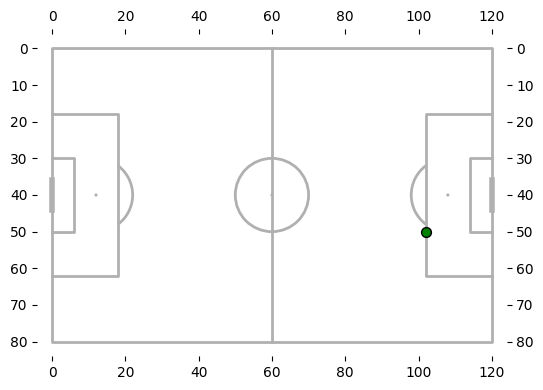

In [39]:
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))
ax.scatter(102, (40 + 10), c='green', s=50, edgecolors='black', zorder=5)
plt.show()

## __Generate Features__

In [81]:
def is_in_attacking_third(location):
    pitch_width = 120

    x = location[0]
    y = location[1]

    attacking_third_start = 2 * (pitch_width / 3)
    return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area

def is_in_middle_third(location):
    pitch_width = 120

    x = location[0]
    y = location[1]

    left_boundary = 1 * (120/3)
    right_boundary = 2 * (120/3)
    return (left_boundary <= x < right_boundary)

def is_in_defending_third(location):
    pitch_width = 120

    x = location[0]
    y = location[1]

    left_boundary = 1 * (120/3)
    return (x < left_boundary)

def is_in_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    # Check if in larger penalty area but NOT in goal area
    x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_in_goal_area(location):
    pitch_width = 120

    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def is_in_edge_of_the_box(location):
    pitch_width = 120

    x = location[0]
    y = location[1]

    x_axis = ((102 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis



def completed_passes(df):
    return (df["pass_outcome"] != "Incomplete") & \
           (df["pass_outcome"] != "Injury Clearance") & \
           (df["pass_outcome"] != "Out") & \
           (df["pass_outcome"] != "Pass Offside") & \
           (df["pass_outcome"] != "Unknown") 

"""
TODO:
Pass accuracy: low, high passes
Cut Back into danger zone
"""

df['under_pressure'] = df['under_pressure'].fillna(False)

player_under_pressure_grouping = df.groupby(['player',"under_pressure"]).agg(
    passes_total=('player', "count"),
    passes_completed = ("pass_outcome", lambda x: ((x != "Incomplete") & (x != "Injury Clearance") & (x != "Out") & (x != "Pass Offside") & (x != "Unknown")).sum()),
    passes_from_final_third=("location", lambda x: x.apply(is_in_attacking_third).sum()),
    passes_from_middle_third=("location", lambda x: x.apply(is_in_middle_third).sum()),
    passes_from_defending_third=("location", lambda x: x.apply(is_in_defending_third).sum()),
    passes_from_the_box=("location", lambda x: x.apply(is_in_penalty_area).sum()),
    passes_into_final_third=("pass_end_location", lambda x: x.apply(is_in_attacking_third).sum()),
    passes_into_box=("pass_end_location", lambda x: x.apply(is_in_penalty_area).sum()), # TODO: from outside to inside
    passes_into_goal_area=("pass_end_location", lambda x: x.apply(is_in_goal_area).sum()),
    passes_total_distance=("pass_length", lambda x: x.sum()),
    passes_short_total=("pass_length", lambda x: ((x >= 5) & (x <= 15)).sum()),
    passes_short_completed=("pass_length", lambda x: (((x >= 5) & (x <= 15)) & completed_passes(df)).sum()),
    passes_medium_completed=("pass_length", lambda x: ((x >= 15) & (x <= 30) & completed_passes(df)).sum()),
    passes_medium_total=("pass_length", lambda x: ((x >= 15) & (x <= 30)).sum()),
    passes_long_total=("pass_length", lambda x: (x >= 30).sum()),
    passes_long_completed=("pass_length", lambda x: ((x >= 30) & completed_passes(df)).sum()),
    passes_switch=("pass_switch", lambda x: (x == True).sum()),
    passes_cross=("pass_cross", lambda x: (x == True).sum()),
    passes_cut_back=("pass_cut_back", lambda x: (x == True).sum()),
    passes_shot_assist=("pass_shot_assist", lambda x: (x == True).sum()),
    passes_goal_assist=("pass_goal_assist", lambda x: (x == True).sum()),
)
player_under_pressure_grouping

passes_total  passes_completed  \
player                        under_pressure                                   
Alessandro Schöpf             False                     10                 9   
                              True                       3                 1   
Andrej Kramarić               False                     25                20   
                              True                      11                 5   
Benedikt Höwedes              False                     50                46   
                              True                       4                 3   
Ermin Bičakčić                False                     47                45   
                              True                       5                 2   
Eugen Polanski                False                     14                14   
                              True                       4                 4   
Fabian Lukas Schär            False                     56                49   
                              True                      16                15   
Jean-Eric Maxim Choupo-Moting False                     25                21   
                              True                       9                 7   
Jens Grahl                    False                     25                20   
Johannes Geis                 False                     74                68   
                              True                      12                 9   
Joël Andre Job Matip          False                     74                70   
                              True                       4                 4   
Kevin Kuranyi                 False                      6                 5   
                              True                       1                 0   
Kevin Volland                 False                     21                10   
                              True                       9                 2   
Klaas-Jan Huntelaar           False                     18                16   
                              True                       6                 5   
Leroy Sané                    False                     27                24   
                              True                       6                 4   
Marco Höger                   False                      3                 3   
Mark Uth                      False                      9                 7   
                              True                      10                 7   
Max Meyer                     False                     32                29   
                              True                      12                 8   
Nadiem Amiri                  False                     13                11   
                              True                       1                 1   
Pavel Kadeřábek               False                     27                22   
                              True                      12                10   
Pirmin Schwegler              False                     23                23   
                              True                      12                11   
Ralf Fährmann                 False                     46                35   
                              True                       2                 1   
Roman Neustädter              False                     48                46   
                              True                       6                 5   
Sead Kolašinac                False                     50                47   
                              True                       8                 4   
Sebastian Rudy                False                     41                35   
                              True                      11                 9   
Tarik Elyounoussi             False                     44                41   
                              True                      16                10   
Tobias Strobl                 False           

In [3]:
df.head()

,player,location,under_pressure,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_shot_assist,pass_switch,pass_technique,pass_through_ball,pass_type,shot_key_pass_id
6,Mark Uth,"[61.0, 40.1]",NaN,NaN,-1.919567,NaN,Left Foot,NaN,NaN,NaN,...,NaN,NaN,Andrej Kramarić,5460.0,NaN,NaN,NaN,NaN,Kick Off,NaN
7,Andrej Kramarić,"[59.4, 38.3]",NaN,NaN,2.536994,NaN,Left Foot,NaN,NaN,NaN,...,NaN,NaN,Sebastian Rudy,6039.0,NaN,NaN,NaN,NaN,NaN,NaN
8,Sebastian Rudy,"[52.3, 45.2]",NaN,NaN,2.390664,NaN,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Fabian Lukas Schär,5537.0,NaN,NaN,NaN,NaN,NaN,NaN
9,Fabian Lukas Schär,"[34.3, 61.9]",NaN,NaN,-1.487222,NaN,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Tobias Strobl,12321.0,NaN,NaN,NaN,NaN,NaN,NaN
10,Tobias Strobl,"[38.5, 22.2]",NaN,NaN,1.705317,NaN,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Ermin Bičakčić,9396.0,NaN,NaN,NaN,NaN,NaN,NaN


## __Visualize Passes__

float64
float64


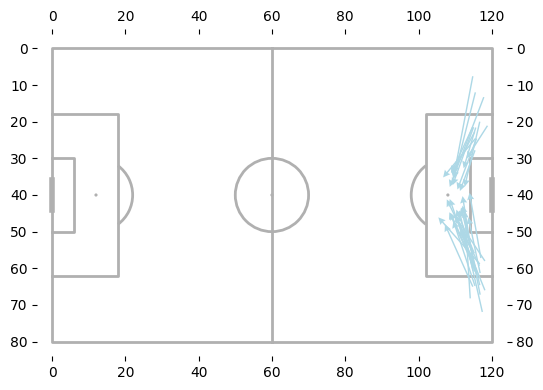

In [ ]:
import math
PI = math.pi

def calculate_degree(radiant):
    return (radiant * (180/3.14))

df["degree"] = df["pass_angle"].apply(calculate_degree)

def is_in_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    attacking_third_start = 2 * (pitch_width / 3)
    return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area

def is_in_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    # Check if in larger penalty area but NOT in goal area
    x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
    y_axis = ((40 - 22) <= y and y <= (40 + 22))
    return x_axis and y_axis

def is_ball_moving_toward_opponent_goal(angle, tolerance=90):
    """
    Checks if the ball's movement angle (in radians) is within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_ball_moving_vertical(angle, max_tolerance=40):
    """
    Checks if the ball's movement is considered to be deep or vertical moving moving along side the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - max_tolerance (float): Maximum angle in degrees .

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle)

def is_ball_moving_horizontal(angle, min_tolerance=75, max_tolerance=105):
    """
    Checks if the ball's movement is primarily horizontal based on the angle between the pass direction and the x-axis.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - min_tolerance (float): Minimum angle in degrees (default is 75°).
    - max_tolerance (float): Maximum angle in degrees (default is 105°).

    Returns:
    - bool: True if the angle is within the specified range, False otherwise.
    """
    normalized_angle = (angle * (180/PI))
    return  max_tolerance >= abs(normalized_angle) >= min_tolerance


def is_ex_inside_goal_area(location):
    #print("Executing is_in_goal_area method")
    pitch_width = 120
    x = location[0]
    y = location[1]

    x_axis = ((pitch_width - 6 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis


def is_ex_inside_penalty_area(location):
    #print("Executing is_in_penalty_area method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location):
        return False
    else:
        # Check if in larger penalty area but NOT in goal area
        x_axis = ((102 <= x) and (x <= pitch_width))  # Stop before goal area
        y_axis = ((40 - 22) <= y and y <= (40 + 22))
        return x_axis and y_axis

def is_ex_inside_attacking_third(location):
    #print("Executing is_in_attacking_third method")
    pitch_width = 120

    x = location[0]
    y = location[1]

    if is_ex_inside_goal_area(location) or is_ex_inside_penalty_area(location):
        return False
    else:
        attacking_third_start = 2 * (pitch_width / 3)
        return (attacking_third_start <= x <= pitch_width)  # Stop before penalty area

def is_progressive_pass(angle, tolerance=75):
    """
    Checks if the ball's movement angle (in radians) is a progressive pass and within the allowed range of angle towards the goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) < tolerance

def is_backward_pass(angle, tolerance=105):
    """
    Checks if the ball's movement angle (in radians) is a defensive pass and within the allowed range of angle towards the own goal.
    
    Parameters:
    - angle (float): The angle in radians (from arctan of y/x).
    - tolerance (float): Maximum angle in degrees (default is 70°).
    
    Returns:
    - bool: True if the angle is within the tolerance, False otherwise.
    """
    normalized_angle = angle * (180 / PI)
    return abs(normalized_angle) > tolerance

def is_in_edge_of_the_box(location):
    pitch_width = 120

    if isinstance(location, str):
        location = convert_to_list(location)

    x = location[0]
    y = location[1]

    x_axis = ((102 <= x) and (x <= pitch_width))
    y_axis = ((40 - 10) <= y and y <= (40 + 10))
    return x_axis and y_axis

def convert_to_list(input_data):
    try:
        return literal_eval(input_data)
    except (ValueError, SyntaxError):
        print(f"Error: The string {input_data} could not be converted to a list.")
        return None

# GCA, SCA - passes into penalty area (except corners)
"""
passing = df[df["location"].apply(is_ex_inside_attacking_third) & (df["pass_end_location"].apply(is_in_penalty_area))
             & (df["pass_type"] != "Corner")]


# GCA - low horizontal passes into penalty area (except corners)

passing = df.loc[df["pass_angle"].apply(is_ball_moving_horizontal) & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "Ground Pass"), :]


# GCA - low vertical passes into penalty area (except corners)


passing = df.loc[(( df["degree"] >= (-50) )  & (df["degree"] <= (50)) & 
              (df["location"].apply(is_ex_inside_attacking_third)) 
              & (df["pass_end_location"].apply(is_in_penalty_area))) & (df["pass_height"] == "Ground Pass"), :]



# GCA - deep (long) low vertical pass from middle third into penalty area   (except corners)
passing = df.loc[(( df["degree"] >= (-50) )  & (df["degree"] <= (50)) & 
              (df["location"].apply(is_in_middle_third)) 
              & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_length"] >= 30))
              & (df["pass_height"] == "Ground Pass"), :]



# GCA - deep (long) low vertical pass from mid third   
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & 
              (df["location"].apply(is_in_middle_third)) & (df["pass_length"] >= 30))
              & (df["pass_height"] == "Ground Pass"), :]


# GCA - deep (long) low vertical pass from defending third
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & (df["pass_length"] >= 30))
                 & (df["location"].apply(is_in_defending_third)) 
              & (df["pass_height"] == "Ground Pass"), :]


# GCA - deep (long) low vertical pass
passing = df.loc[(( df["degree"] >= (-40) ) & (df["degree"] <= (40)) & (df["pass_length"] >= 30)) 
                 & (df["pass_height"] == "Ground Pass"), :]


# GCA - flanke/high/chip horizontal passes into penalty area (except corners) 
passing = df.loc[ (df["pass_angle"].apply(is_ball_moving_horizontal))  & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "High Pass"), :]


# GCA - high chip vertical passes into penalty area (except corners) # (( df["degree"] >= (-50) )  & (df["degree"] <= (50)))
passing = df.loc[ (df["pass_angle"].apply(is_ball_moving_vertical))  & (df["location"].apply(is_ex_inside_attacking_third)) 
                 & (df["pass_end_location"].apply(is_in_penalty_area)) & (df["pass_type"] != "Corner")
                 & (df["pass_height"] == "High Pass"), :]

# GCA, SCA - flat Backward Pass into danger zone (except corner)
passing = df.loc[(df["location"].apply(is_ex_inside_attacking_third)) & (df["pass_angle"].apply(is_backward_pass)) 
                 & (df["location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner") & (df["pass_height"] == "Ground Pass") , :]

# GCA, SCA - general Backward Pass into danger zone (except corner)
passing = df.loc[(df["location"].apply(is_ex_inside_attacking_third)) & (df["pass_angle"].apply(is_backward_pass)) 
                 & (df["location"].apply(is_in_edge_of_the_box)) & (df["pass_type"] != "Corner"), :]

# defensive pass                 
passing = df.loc[(df["pass_angle"].apply(is_backward_pass)) &  ~(df["location"].apply(is_in_attacking_third)) 
& (df["pass_type"] != "Corner"), :]

# low vertical passes into danger zone
passing = df.loc[(df["pass_angle"].apply(is_ball_moving_vertical)) &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) 
& (df["pass_type"] != "Corner")  & (df["pass_height"] == "Ground Pass"), :]


# high chip vertical passes into danger zone
passing = df.loc[(df["pass_angle"].apply(is_ball_moving_vertical)) &  (df["pass_end_location"].apply(is_in_edge_of_the_box)) 
& (df["pass_type"] != "Corner")  & (df["pass_height"] == "High Pass"), :]

"""

passing = df.loc[(df["pass_cut_back"] == True) & (df["pass_end_location"].apply(is_in_edge_of_the_box)), :]

if MATCH:
    start_location = np.vstack([passes for passes in passing["location"]])
    end_location = np.vstack([passes for passes in passing["pass_end_location"]])

else:
    start_location = np.vstack([literal_eval(passes) for passes in passing["location"]])
    end_location = np.vstack([literal_eval(passes) for passes in passing["pass_end_location"]])

# Calculate the change in x and y (vector direction)
dx = end_location[:, 0] - start_location[:, 0]  # difference in x (end_x - start_x)
dy = end_location[:, 1] - start_location[:, 1]  # difference in y (end_y - start_y)

# Draw pitch
pitch = Pitch(label=True, tick=True)
fig, ax = pitch.draw(figsize=(8, 4))

# Plot arrows using ax.quiver (from start_location to end_location)
ax.quiver(
    start_location[:, 0], start_location[:, 1],  # starting points (x, y)
    dx, dy,  # vector components (dx, dy)
    color='lightblue', scale_units='xy', angles='xy', scale=1, width=0.003, headlength=5, headwidth=5, zorder=5
)

plt.show()

In [97]:
df.loc[(df["pass_cut_back"] == True), :]

,player,location,under_pressure,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_switch,pass_technique,pass_through_ball,pass_type,shot_key_pass_id,degree
471,Tarik Elyounoussi,"[115.7, 23.7]",True,NaN,1.715758,e06ae8d9-fdf1-434d-8526-77b9de23c2d5,Left Foot,True,True,NaN,...,NaN,NaN,Mark Uth,8387.0,NaN,NaN,NaN,NaN,NaN,98.355537


In [59]:
passing.columns

Index(['player', 'location', 'under_pressure', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_shot_assist', 'pass_height',
       'pass_inswinging', 'pass_length', 'pass_outcome', 'pass_outswinging',
       'pass_recipient', 'pass_recipient_id', 'pass_switch', 'pass_technique',
       'pass_through_ball', 'pass_type', 'shot_key_pass_id', 'degree'],
      dtype='object')

In [78]:
passing

,player,location,under_pressure,pass_aerial_won,pass_angle,pass_assisted_shot_id,pass_body_part,pass_cross,pass_cut_back,pass_deflected,...,pass_outcome,pass_outswinging,pass_recipient,pass_recipient_id,pass_switch,pass_technique,pass_through_ball,pass_type,shot_key_pass_id,degree
81,Pavel Kadeřábek,"[117.7, 60.6]",NaN,NaN,-1.886412,ba46e9d6-e828-4599-952c-39c1f7d22659,Right Foot,True,NaN,NaN,...,NaN,NaN,Tarik Elyounoussi,26832.0,NaN,NaN,NaN,NaN,NaN,-108.138268
218,Younès Belhanda,"[88.8, 31.7]",NaN,NaN,-0.625721,d9cea903-f92a-40e1-a393-1a849d83f157,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Klaas-Jan Huntelaar,8060.0,NaN,NaN,NaN,NaN,NaN,-35.869331
302,Benedikt Höwedes,"[87.4, 71.3]",NaN,NaN,-0.978655,92ef54cd-5bb9-4b42-9d82-e60aa070e5a8,Right Foot,True,NaN,NaN,...,NaN,NaN,Klaas-Jan Huntelaar,8060.0,NaN,NaN,NaN,NaN,NaN,-56.101225
303,Johannes Geis,"[120.0, 80.0]",NaN,NaN,-1.850475,fd99f442-49ae-4724-87e8-2512e4a5d9c6,Right Foot,NaN,NaN,NaN,...,NaN,True,Joël Andre Job Matip,3502.0,NaN,Outswinging,NaN,Corner,NaN,-106.078173
465,Jean-Eric Maxim Choupo-Moting,"[107.8, 26.5]",NaN,NaN,2.758849,c4d9a52d-7469-472f-a7e1-70d5a0fe2049,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Klaas-Jan Huntelaar,8060.0,NaN,NaN,NaN,NaN,NaN,158.150585
518,Tarik Elyounoussi,"[89.0, 37.5]",NaN,NaN,-0.671272,cb389b59-0d50-4094-9bcb-5ddfab790447,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Kevin Volland,8215.0,NaN,NaN,NaN,NaN,NaN,-38.480546
519,Sebastian Rudy,"[120.0, 0.1]",NaN,NaN,1.716809,4aaf9747-c33d-4f76-bb0f-d25ad1ebe7c6,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Mark Uth,8387.0,NaN,Inswinging,NaN,Corner,NaN,98.415780
595,Kevin Volland,"[94.5, 48.8]",NaN,NaN,-1.689054,3a04baf2-b287-40c9-b614-608b323087c9,Left Foot,NaN,NaN,NaN,...,NaN,NaN,Andrej Kramarić,5460.0,NaN,NaN,NaN,NaN,NaN,-96.824746
660,Younès Belhanda,"[44.9, 43.0]",NaN,NaN,0.434004,d740d3a5-3ebb-4887-8b11-2153ad9e958f,Right Foot,NaN,NaN,NaN,...,NaN,NaN,Leroy Sané,3053.0,NaN,NaN,NaN,NaN,NaN,24.879207
722,Leroy Sané,"[106.9, 62.1]",NaN,NaN,-1.556908,4cd68d3a-7161-4803-9c2c-75771fb67c82,Left Foot,True,NaN,NaN,...,NaN,NaN,Max Meyer,8508.0,NaN,NaN,NaN,NaN,NaN,-89.249526


In [35]:
passing["cut-back"]

KeyError: 'cut-back'

thoughts:
- horizontal passes in middle third are not progressive or gca
- horizontal passes into final third are progressive and gca
- vertical passes into final third are progressive and gca
- vertical passes into the box are progressicve and gca
- short passes in corner area are not progressive and not gca

In [171]:
passing.columns

Index(['player', 'location', 'under_pressure', 'pass_aerial_won', 'pass_angle',
       'pass_assisted_shot_id', 'pass_body_part', 'pass_cross',
       'pass_cut_back', 'pass_deflected', 'pass_end_location',
       'pass_goal_assist', 'pass_height', 'pass_inswinging', 'pass_length',
       'pass_outcome', 'pass_outswinging', 'pass_recipient',
       'pass_recipient_id', 'pass_shot_assist', 'pass_switch',
       'pass_technique', 'pass_through_ball', 'pass_type', 'shot_key_pass_id',
       'degree'],
      dtype='object')

## __Pass Outcome__

assisted_shot_id, pass_shot_assist, shot-assist, goal-assist 

In [180]:
passing["pass_shot_assist"].value_counts(), passing["pass_goal_assist"].value_counts()

(pass_shot_assist
 True    6
 Name: count, dtype: int64,
 pass_goal_assist
 True    1
 Name: count, dtype: int64)